In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab_Notebooks/AdvancedDeepLearningCourse/Session05/DCGAN')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

from keras.layers import Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten
from keras.layers import Layer, Reshape, BatchNormalization, Activation, Input
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
# hyper parameters

latent_dim = 100
image_size = 28
image_shape = (image_size, image_size, 1)

gen_filters = [128, 64, 32, 1]
gen_strides = [2, 2, 1, 1]

dis_filters = [32, 64, 128, 256]
dis_strides = [2, 2, 2, 1]


kernel_size = 5
strides = 2
alpha = 0.2

batch_size = 64

dis_lr = 2e-4
dis_decay = 6e-8
dis_optimizer = RMSprop(lr=dis_lr, decay=dis_decay)

adv_lr = dis_lr * 0.5
adv_decay = dis_decay * 0.5
adv_optimizer = RMSprop(lr=adv_lr, decay=adv_decay)

save_intervals = 500
train_steps = 40000
log_print_steps = 50
test_size = 16

In [0]:
# load MNIST dataset...
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape((-1, image_size, image_size, 1)).astype('float32')/255

In [0]:
os.makedirs('images', exist_ok=True)

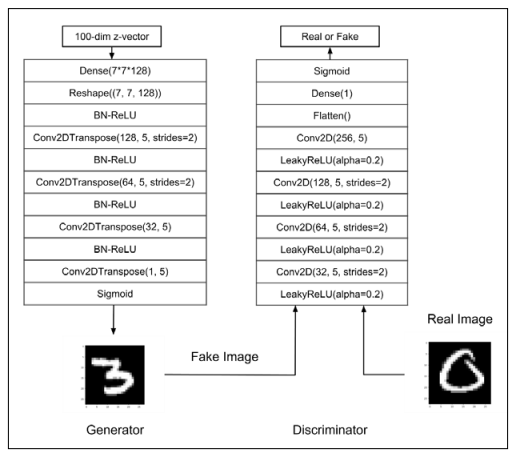

In [52]:
from IPython.display import Image
Image('dcgan.PNG')

In [0]:
def bn_relu(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x 

In [0]:
def build_generator(inputs, image_size=28):    
    """Build a Generator Model
        Stack of BN-ReLU-Conv2DTranpose to generate fake images.
        Output activation is sigmoid instead of tanh in [1].
        Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Generator Model
    """
    filters = gen_filters 
    x = inputs
    
    image_resize = image_size // 4
    
    x = Dense(image_resize * image_resize * filters[0])(x)
    x = Reshape((image_resize, image_resize, filters[0]))(x)
    
    
    for strides, filter in zip(gen_strides, filters):
        x = bn_relu(x)
        x = Conv2DTranspose(filters = filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides= strides
                           )(x)
    outputs = Activation('sigmoid', name='Sigmoid')(x)
    model =Model(inputs, outputs, name='generator')
    model.summary()
    plot_model(model, to_file='generator.png', show_shapes=True)
    return model

In [0]:
def build_discriminator(inputs):
    
    """ Build a Discriminator Model
        Stack of LeakyReLU-Conv2D to discriminate real from fake.
        The network does not converge with BN so it is not used here
        unlike in [1] or original paper.
        # Arguments
            inputs (Layer): Input layer of the discriminator (the image)
        # Returns
            Model: Discriminator Model
    """
    x = inputs
    for strides, filter in zip(dis_strides, dis_filters):
        x = LeakyReLU(alpha=alpha)(x)
        x = Conv2D(filters = filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides= strides
                           )(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    outputs = Activation('sigmoid', name='Sigmoid')(x)
    model = Model(inputs, outputs, name='discriminator')
    return model        

In [0]:
def build_and_train():
    
    dis_inputs = Input(shape=image_shape, name='dis_inputs')
    dis = build_discriminator(dis_inputs)
    dis.compile(loss='binary_crossentropy',
                optimizer=dis_optimizer,
                metrics=['acc']
               )
    
    gen_inputs = Input(shape=(latent_dim,), name='gen_inputs')
    gen = build_generator(gen_inputs)
    
    
    
    dis.trainable = False
    adv_inputs = gen_inputs
    adv_outputs = dis(gen(gen_inputs))
    adv = Model(adv_inputs, adv_outputs, name='adversarial')
    adv.compile(loss='binary_crossentropy',
                optimizer=adv_optimizer,
                metrics=['acc']
               )
    adv.summary()
    plot_model(adv, to_file='adversarial.png', show_shapes=True)
    
    models = gen, dis, adv
    
    train(models)


In [0]:
def train(models):
    """
        Train the Discriminator and Adversarial Networks
        Alternately train Discriminaor and Adversarial networks by batch.
        Discriminator is trained first with properly real and fake images.
        Adversarial is trained next with fake images pretending to be real
        Generate sample images per save_interval.
    
    # Arguments
        models (tuple): Generator, Discriminator, Adversarial models
    """
    
    gen, dis, adv = models
    m_train = x_train.shape[0]
    
    test_z = np.random.uniform(low=-1, high=+1, size=[test_size, latent_dim])
    
    for step in range(1, train_steps + 1):
        random_indices = np.random.randint(0, m_train, size=batch_size)
        real_images = x_train[random_indices]
        
        
        z = np.random.uniform(low=-1, high=+1, size=[batch_size, latent_dim])
        fake_images = gen.predict(z)
        
        
        fake_labels = np.zeros((batch_size, 1))
        real_labels = np.ones((batch_size, 1))
        
        dis_x = np.concatenate([real_images, fake_images])
        dis_y = np.concatenate([real_labels, fake_labels])
        
        loss, acc = dis.train_on_batch(dis_x, dis_y)
        log = f'step:{step} dis[loss:{loss}, acc:{acc}]'
        
        adv_x = np.random.uniform(low=-1, high=+1, size=[batch_size, latent_dim])
        adv_y = np.ones((batch_size, 1))
        
        loss, acc= adv.train_on_batch(adv_x, adv_y)
        log += f'adv[loss:{loss}, acc:{acc}]'
        
        print(log)
        if step % save_intervals == 0:
            plot_images(gen, test_z, step)
            

In [0]:
def plot_images(generator, noise_input, step, show=False):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
    """
    image_address = 'images'
    
    z = noise_input
    n_images = z.shape[0]
    
    rows = np.sqrt(n_images)
    plt.figure(figsize=(2, 2))
    images = generator.predict(z)
    image_size = images.shape[1]
    
    for i in range(n_images):
        plt.subplot(rows,rows, i+1)
        plt.imshow(images[i].reshape((image_size, image_size)), cmap='gray')
        plt.axis('off')
    plt.savefig(os.path.join(image_address , f"{step}.png"))
    
    if show:
        plt.show()
    else:
        plt.close('all')

In [63]:
build_and_train()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_inputs (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_11 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
activation_41 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_42 (Batc (None, 14, 14, 128)       51

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step:1 dis[loss:0.6975302696228027, acc:0.4453125]adv[loss:1.042691946029663, acc:0.0]
step:2 dis[loss:0.6325287818908691, acc:0.5]adv[loss:1.1263514757156372, acc:0.0]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step:3 dis[loss:0.5091824531555176, acc:0.9765625]adv[loss:1.5345489978790283, acc:0.0]
step:4 dis[loss:0.3442114591598511, acc:0.9765625]adv[loss:1.2682116031646729, acc:0.0]
step:5 dis[loss:0.20301023125648499, acc:1.0]adv[loss:3.1607463359832764, acc:0.0]
step:6 dis[loss:0.27141571044921875, acc:0.8984375]adv[loss:0.8290906548500061, acc:0.0]
step:7 dis[loss:0.17132458090782166, acc:1.0]adv[loss:2.5567336082458496, acc:0.0]
step:8 dis[loss:0.16818583011627197, acc:0.953125]adv[loss:1.215985894203186, acc:0.0]
step:9 dis[loss:0.06813258677721024, acc:0.9921875]adv[loss:0.496553897857666, acc:0.984375]
step:10 dis[loss:0.05317007750272751, acc:1.0]adv[loss:0.18653550744056702, acc:1.0]
step:11 dis[loss:0.03759434074163437, acc:1.0]adv[loss:0.16079676151275635, acc:1.0]
step:12 dis[loss:0.025239890441298485, acc:1.0]adv[loss:0.13143520057201385, acc:1.0]
step:13 dis[loss:0.027771398425102234, acc:1.0]adv[loss:0.08788134157657623, acc:1.0]
step:14 dis[loss:0.02281070500612259, acc:1.0]a

KeyboardInterrupt: ignored

In [0]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

*:)*